## Exploratory Data Analysis

The Labeled Faces in the Wild (LFW) dataset is a benchmark dataset widely used in facial recognition research.

Key Features of the LFW Dataset
1. Purpose:
Designed for face verification tasks, where the goal is to determine whether two images belong to the same person.
Often used for face identification tasks as well.

2. Dataset Composition:
Total Images: 13,233 images.
Number of Individuals: 5,749 individuals.
Number of Images per Person:
Some individuals have many images (e.g., celebrities, public figures), while others have only one.
Images are collected from the web and represent real-world scenarios.
3. Image Details:
Resolution: Varies, but commonly used versions include resized versions (e.g., 64×64 or 128×128).
Color: RGB images.
Format: JPEG.

Number of classes (people): 5749
Total number of images: 13233


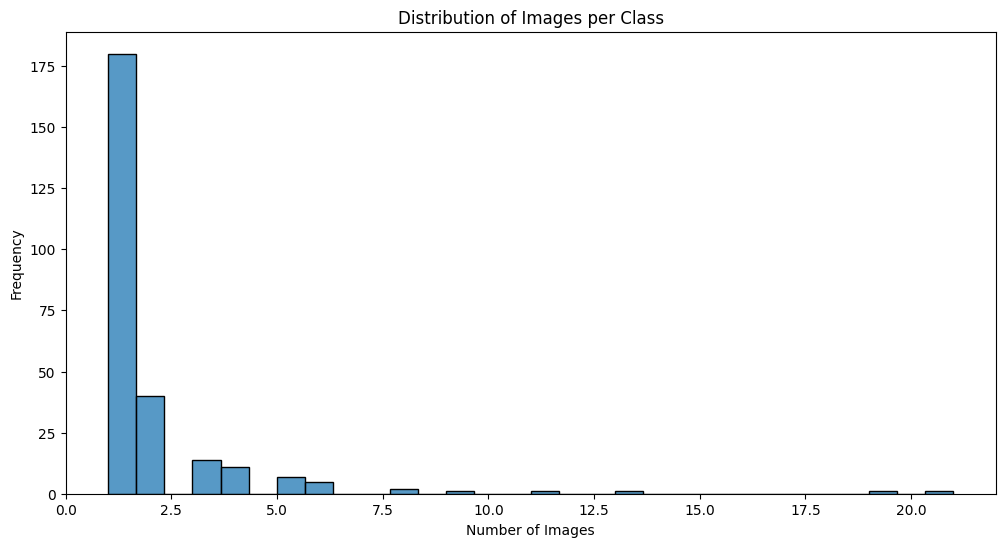

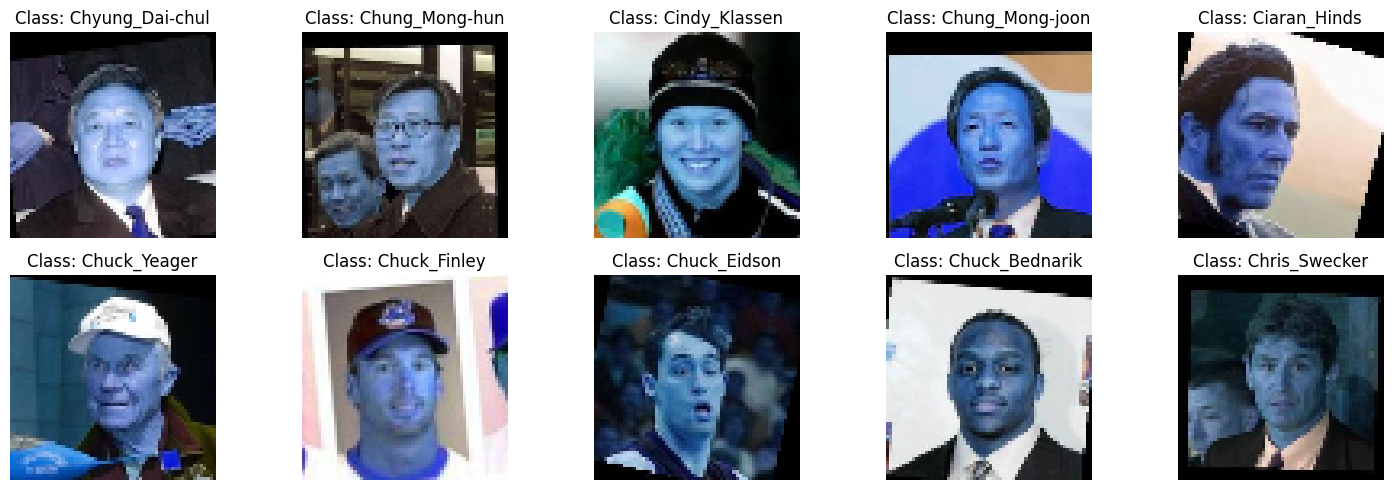

Mean pixel values (RGB): [ 84.10690381  93.78387354 107.78841504]
Std dev of pixel values (RGB): [61.34125413 64.0795567  70.02512706]


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Path to the dataset
dataset_path = "/content/drive/MyDrive/lfw-deepfunneled"
image_size = (64, 64)

# Load dataset structure
def get_dataset_info(dataset_path):
    classes = []
    num_images = 0

    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            classes.append(person)
            num_images += len(os.listdir(person_path))

    return classes, num_images

# Load a subset of images and labels for analysis
def load_images_for_eda(dataset_path, image_size=(64, 64), max_samples=10):
    images, labels = [], []
    label_map = {}
    current_label = 0
    samples_loaded = 0

    for person in os.listdir(dataset_path):
        if samples_loaded >= max_samples:
            break

        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            if person not in label_map:
                label_map[person] = current_label
                current_label += 1
            for img_file in os.listdir(person_path):
                if samples_loaded >= max_samples:
                    break
                img_path = os.path.join(person_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(label_map[person])
                    samples_loaded += 1

    return np.array(images), np.array(labels), label_map

# Dataset overview
classes, num_images = get_dataset_info(dataset_path)
print(f"Number of classes (people): {len(classes)}")
print(f"Total number of images: {num_images}")

# Load a sample for EDA
sample_images, sample_labels, label_map = load_images_for_eda(dataset_path, image_size=image_size, max_samples=500)
label_counts = Counter(sample_labels)

# Plot label distribution
plt.figure(figsize=(12, 6))
sns.histplot(list(label_counts.values()), bins=30, kde=False)
plt.title("Distribution of Images per Class")
plt.xlabel("Number of Images")
plt.ylabel("Frequency")
plt.show()

# Display a few sample images
def plot_sample_images(images, labels, label_map, num_samples=10):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 5))

    for i in range(min(num_samples, len(unique_labels))):
        sample_idx = np.where(labels == unique_labels[i])[0][0]
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[sample_idx].astype("uint8"))
        plt.title(f"Class: {list(label_map.keys())[unique_labels[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_sample_images(sample_images, sample_labels, label_map)

# Analyze image statistics
def analyze_image_statistics(images):
    means = [np.mean(img, axis=(0, 1)) for img in images]
    std_devs = [np.std(img, axis=(0, 1)) for img in images]

    mean_values = np.mean(means, axis=0)
    std_values = np.mean(std_devs, axis=0)

    print(f"Mean pixel values (RGB): {mean_values}")
    print(f"Std dev of pixel values (RGB): {std_values}")

analyze_image_statistics(sample_images)

## Model

In [10]:
def build_fixed_cnn(input_shape=(64, 64, 3), num_classes=None):
    inputs = Input(shape=input_shape)

    # First block
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second block
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Third block
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)

    # Classification layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model



# Convert labels to numpy array if they aren't already
labels = np.array(labels)

# Print dataset statistics
print(f"Number of images: {len(images)}")
print(f"Number of unique classes: {len(label_map)}")
print(f"Label range: {np.min(labels)} to {np.max(labels)}")

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Build the model
model = build_fixed_cnn(input_shape=(64, 64, 3), num_classes=len(label_map))

# Compile with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]
)

# Save the model
model.save("fixed_cnn_model.h5")

Number of images: 13233
Number of unique classes: 5749
Label range: 0 to 5748


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5749)                │       2,949,237 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,240,245 (27.62 MB)

 Trainable params: 7,238,773 (27.61 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 190s 563ms/step - accuracy: 0.0306 - loss: 8.3696 - val_accuracy: 0.0419 - val_loss: 7.9395 - learning_rate: 1.0000e-04
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 187s 566ms/step - accuracy: 0.0695 - loss: 6.6962 - val_accuracy: 0.0706 - val_loss: 7.8130 - learning_rate: 1.0000e-04
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 189s 571ms/step - accuracy: 0.1034 - loss: 5.8903 - val_accuracy: 0.0914 - val_loss: 7.8833 - learning_rate: 1.0000e-04
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 204s 576ms/step - accuracy: 0.1588 - loss: 5.0722 - val_accuracy: 0.1020 - val_loss: 7.8970 - learning_rate: 1.0000e-04
Epoch 5/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 197s 562ms/step - accuracy: 0.2601 - loss: 4.2716 - val_accuracy: 0.1103 - val_loss: 7.9759 - learning_rate: 1.0000e-04
Epoch 6/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 199s 555ms/step - accuracy: 0.4575 - loss: 3.4553 - val_accuracy: 0.1201 - val_loss: 7.9479 - learning_rate: 5.0000e-05
Epoch 7/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
# Inference example: Generate embeddings
def get_embeddings(model, images):
    return model.predict(images)

# Example of generating embeddings
sample_images = X_val[:5]
embeddings = get_embeddings(base_model, sample_images)

# Use embeddings for verification
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

print("Cosine similarity between two samples:")
print(cosine_similarity(embeddings[0], embeddings[1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Cosine similarity between two samples:
0.97861177


## Visualization


Dataset Statistics:
Total number of people: 5749
Total number of images: 13233
Average images per person: 2.3
Median images per person: 1.0
Min images per person: 1
Max images per person: 530


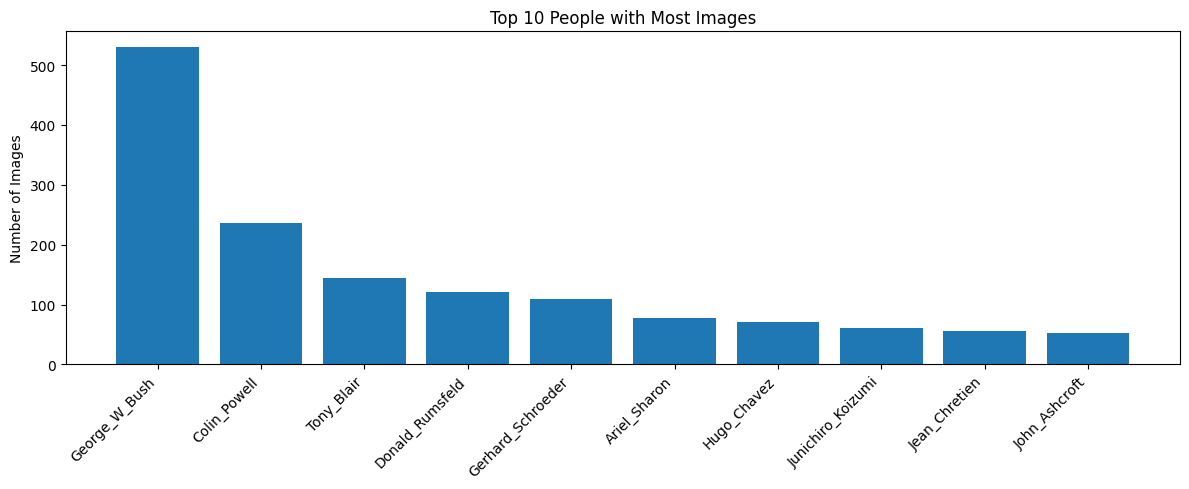

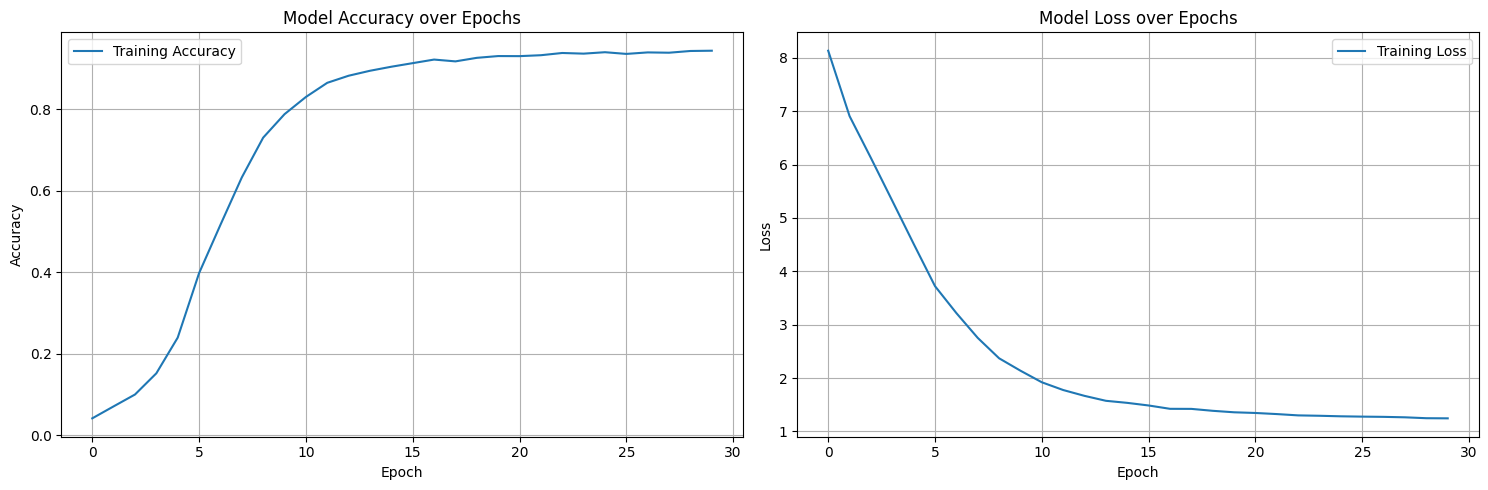

83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step

Overall Accuracy: 0.1526


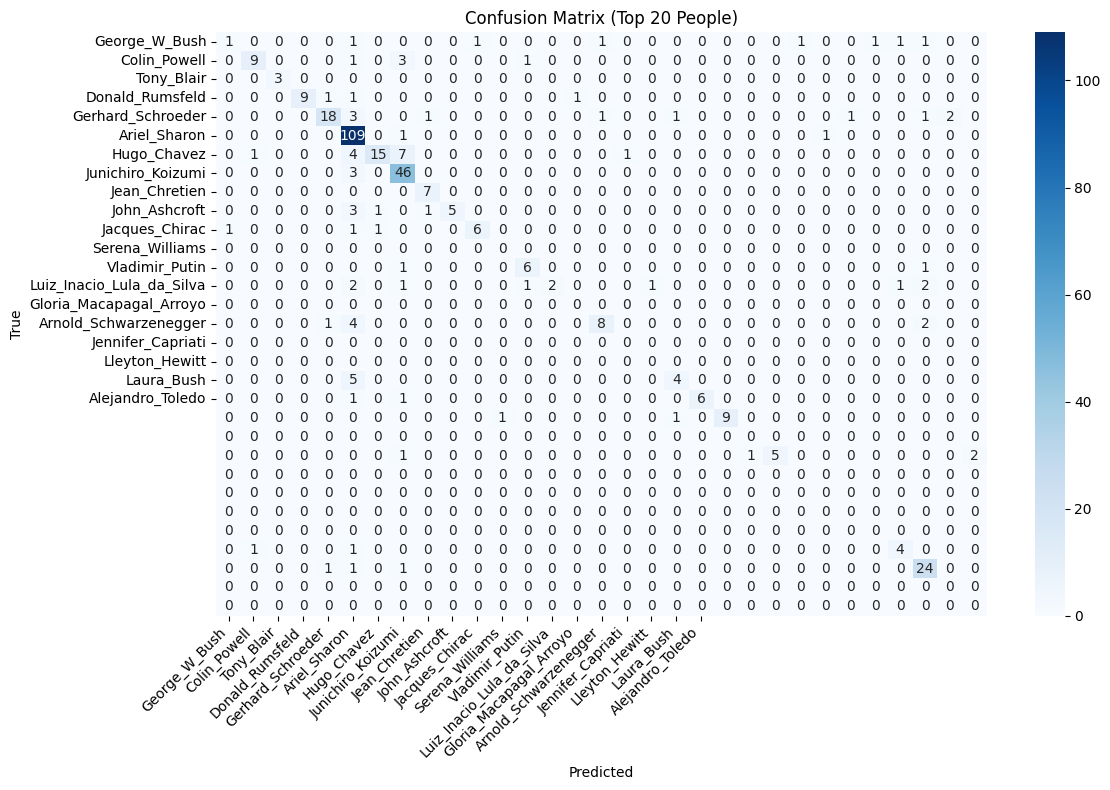

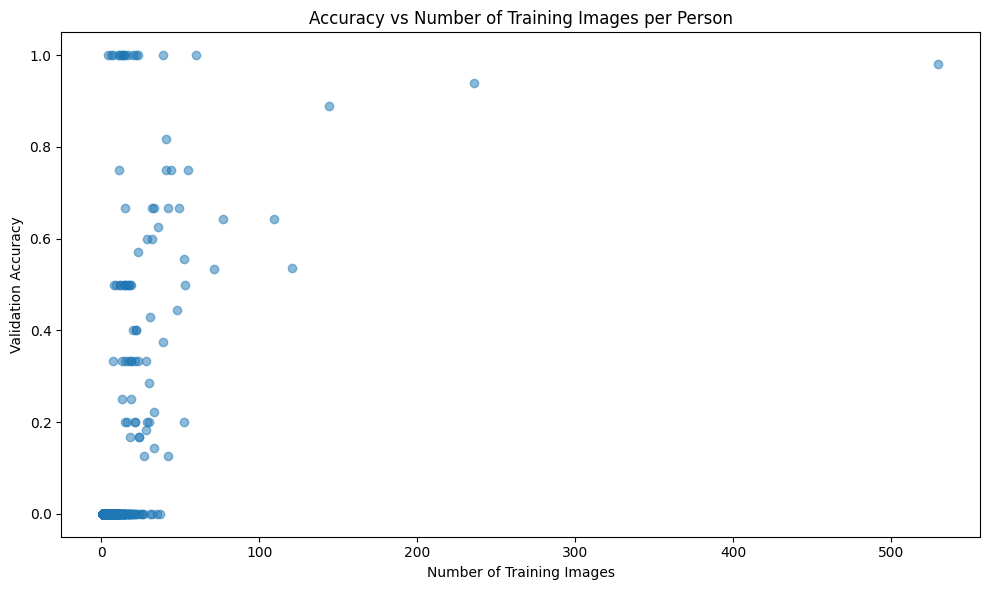

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import cv2

def analyze_lfw_dataset(dataset_path):
    """Analyze LFW dataset structure and distribution."""
    # Count images per person
    person_counts = {}
    total_images = 0

    for person in os.listdir(dataset_path):
        person_dir = os.path.join(dataset_path, person)
        if os.path.isdir(person_dir):
            num_images = len(os.listdir(person_dir))
            person_counts[person] = num_images
            total_images += num_images

    counts = list(person_counts.values())

    # Print dataset statistics
    print(f"\nDataset Statistics:")
    print(f"Total number of people: {len(person_counts)}")
    print(f"Total number of images: {total_images}")
    print(f"Average images per person: {np.mean(counts):.1f}")
    print(f"Median images per person: {np.median(counts):.1f}")
    print(f"Min images per person: {np.min(counts)}")
    print(f"Max images per person: {np.max(counts)}")

    # Show top 10 people with most images
    top_people = dict(sorted(person_counts.items(),
                           key=lambda x: x[1], reverse=True)[:10])

    plt.figure(figsize=(12, 5))
    plt.bar(top_people.keys(), top_people.values())
    plt.title('Top 10 People with Most Images')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

    return person_counts

def plot_training_history(history):
    """Plot training and validation metrics."""
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def analyze_model_performance(model, X_val, y_val, label_map, person_counts, top_n=20):
    """Analyze model performance with focus on LFW characteristics."""
    # Get predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate overall accuracy
    accuracy = np.mean(y_pred_classes == y_val)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Get people with most images
    top_people = dict(sorted(person_counts.items(),
                           key=lambda x: x[1], reverse=True)[:top_n])
    top_indices = [list(label_map.keys()).index(person) for person in top_people.keys()]

    # Filter data for top people
    mask = np.isin(y_val, top_indices)
    y_true_filtered = y_val[mask]
    y_pred_filtered = y_pred_classes[mask]

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    cm = confusion_matrix(y_true_filtered, y_pred_filtered)
    sns.heatmap(cm, xticklabels=list(top_people.keys()),
                yticklabels=list(top_people.keys()),
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Top {top_n} People)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Analyze accuracy vs number of training images
    class_accuracies = {}
    for label, name in enumerate(label_map.keys()):
        if name in person_counts:
            mask = (y_val == label)
            if np.sum(mask) > 0:  # Only include if we have validation samples
                class_accuracies[name] = {
                    'accuracy': np.mean(y_pred_classes[mask] == y_val[mask]),
                    'num_images': person_counts[name]
                }

    # Plot accuracy vs number of images
    plt.figure(figsize=(10, 6))
    plt.scatter([d['num_images'] for d in class_accuracies.values()],
                [d['accuracy'] for d in class_accuracies.values()],
                alpha=0.5)
    plt.xlabel('Number of Training Images')
    plt.ylabel('Validation Accuracy')
    plt.title('Accuracy vs Number of Training Images per Person')
    plt.tight_layout()
    plt.show()

# First, analyze the dataset structure
person_counts = analyze_lfw_dataset(dataset_path)

# Plot training history
plot_training_history(history)

# Analyze model performance
analyze_model_performance(model, X_val, y_val, label_map, person_counts, top_n=20)

##Structure of the Confusion Matrix:


Rows represent the true identity (actual person)

Columns represent the predicted identity (who the model thinks it is)

Each cell value shows how many times a particular prediction occurred

The diagonal cells (top-left to bottom-right) show correct predictions

Off-diagonal cells show misclassifications